Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


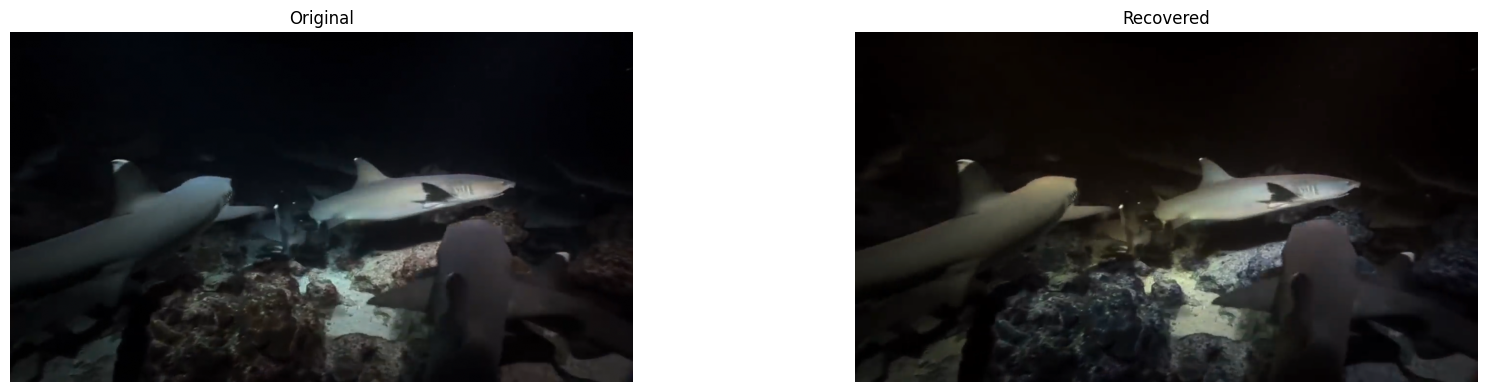

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


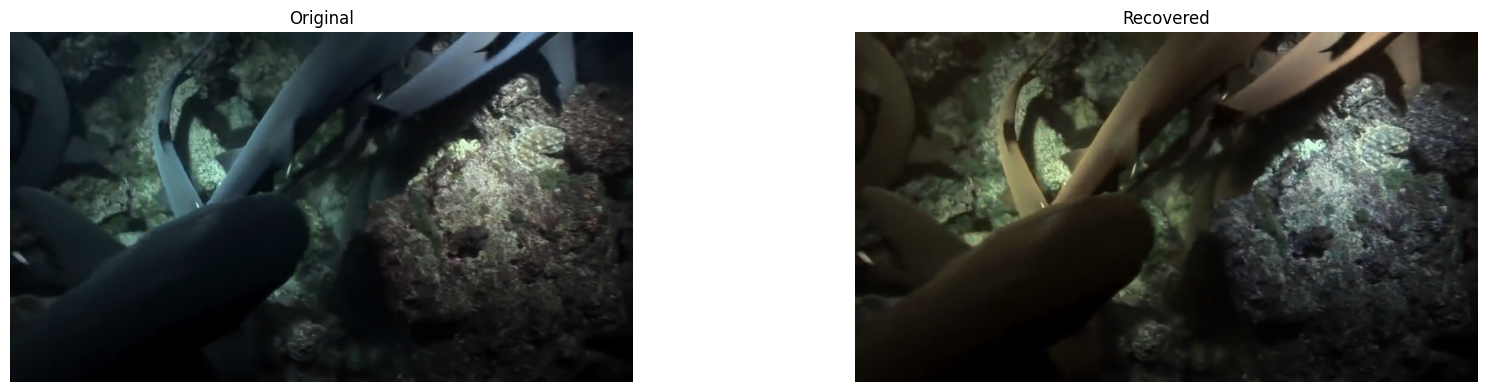

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


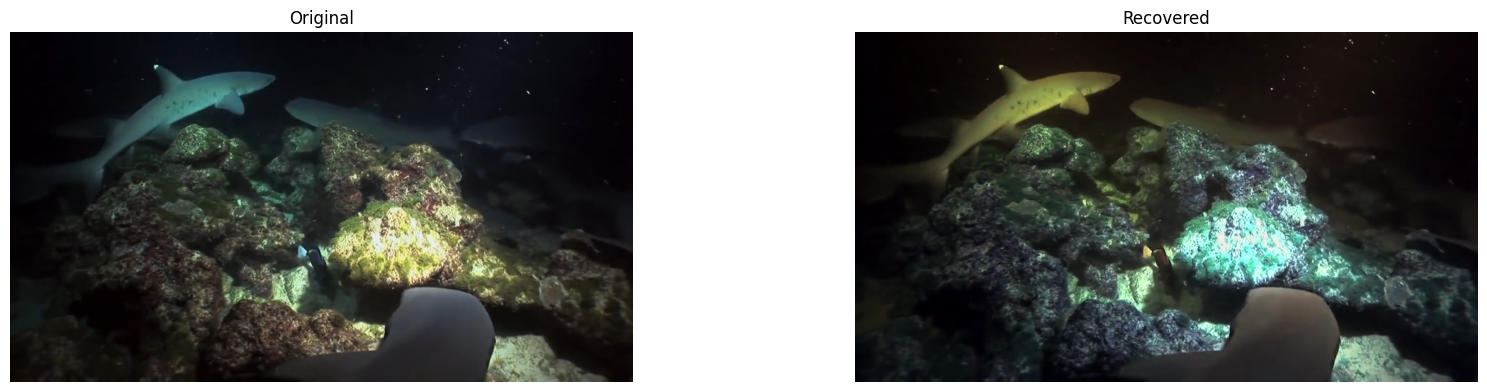

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


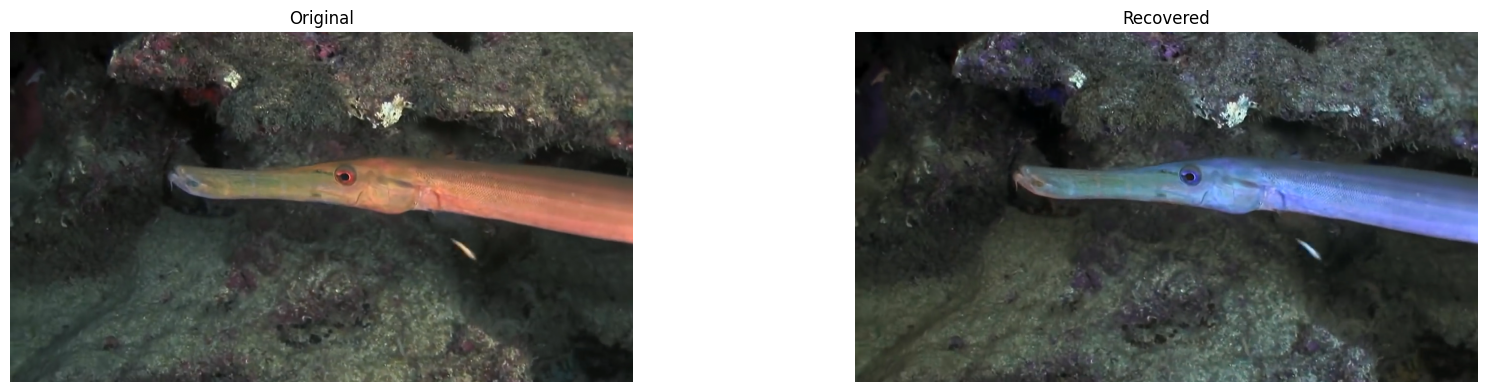

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


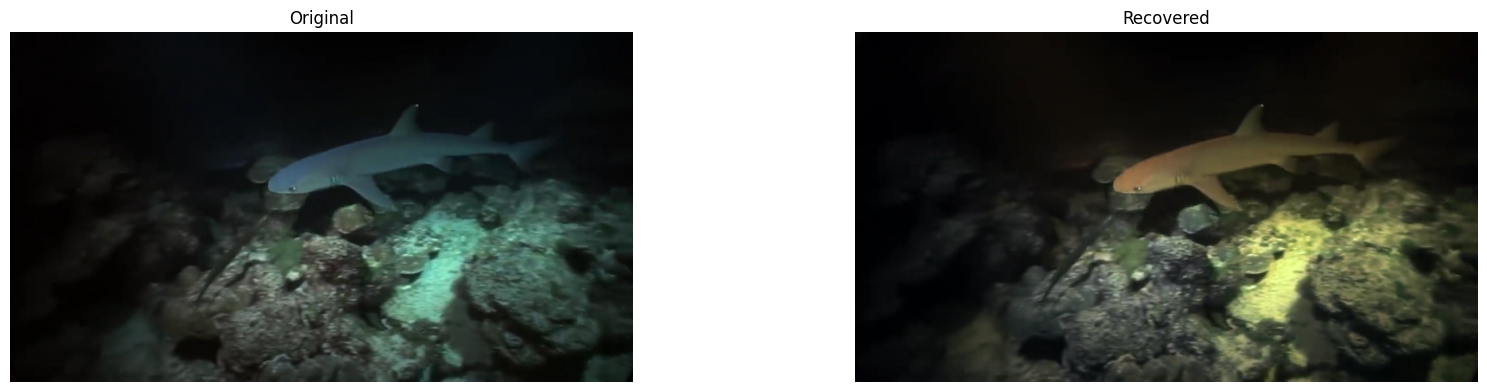

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


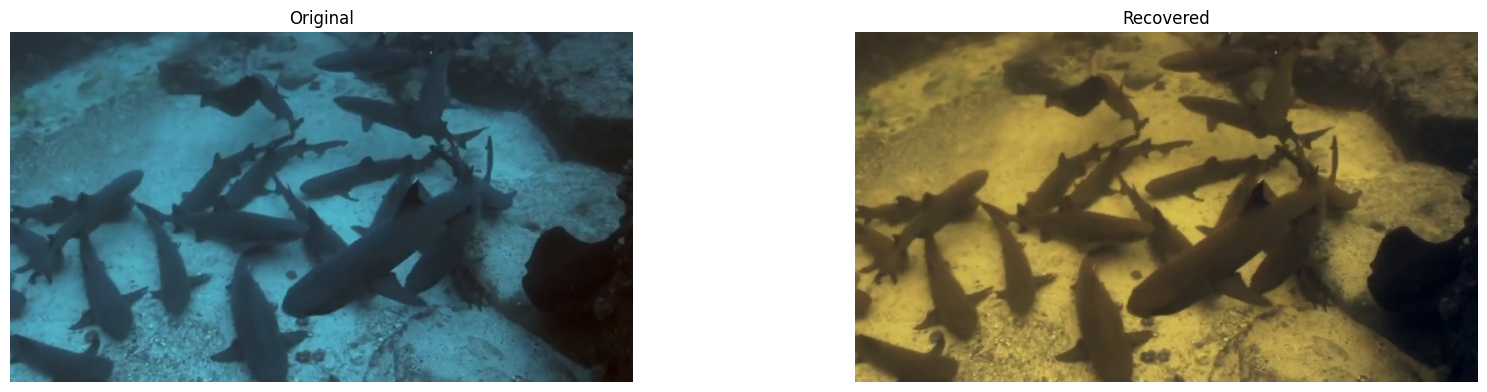

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


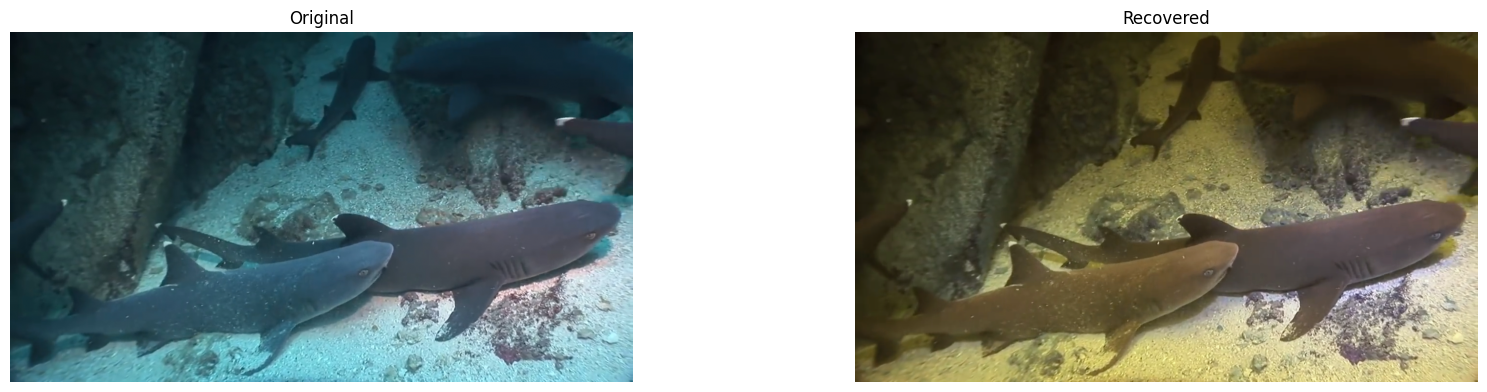

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


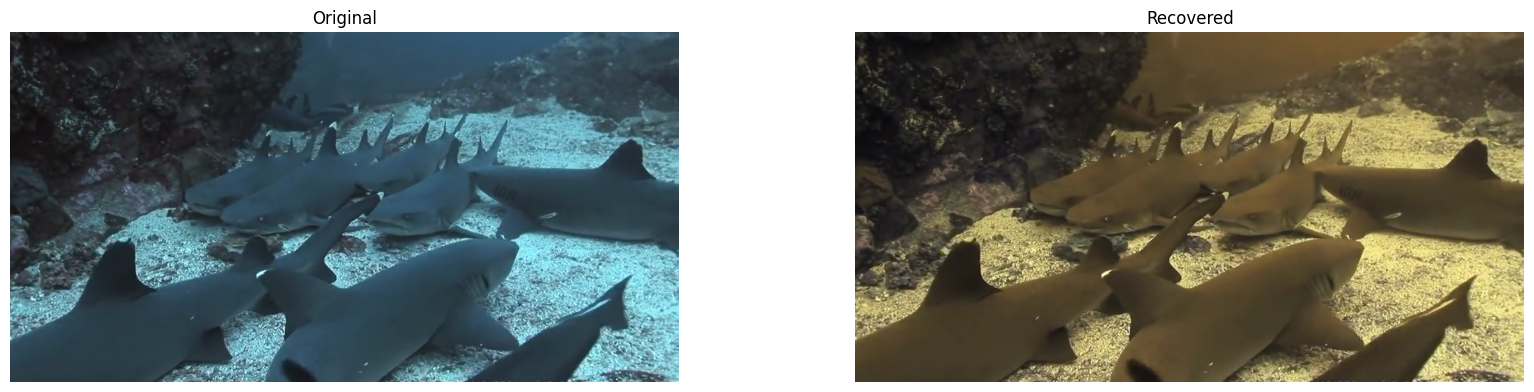

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


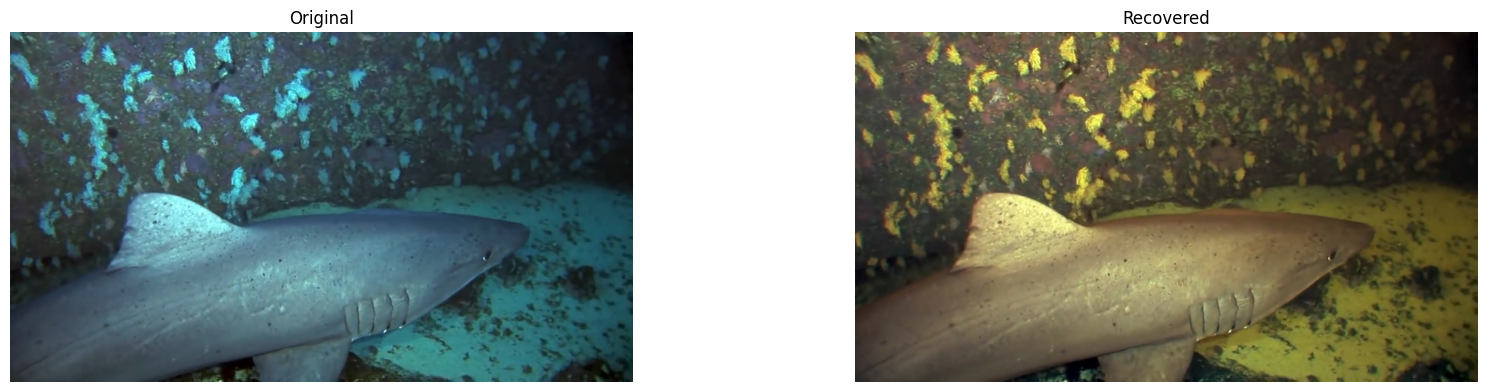

In [4]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import os


def dark_saturation_prior(image):
    b, g, r = cv2.split(image)
    max_of_rgb=cv2.max(cv2.max(r, g), b)
    min_of_rgb=cv2.min(cv2.min(r, g), b)

    height, width = max_of_rgb.shape
    saturation = np.zeros((height, width), dtype=np.float64)

    for i in range(height):
        for j in range(width):
            if max_of_rgb[i, j] != 0:
                saturation[i, j] = (max_of_rgb[i, j] - min_of_rgb[i, j]) / max_of_rgb[i, j]

    dc = cv2.min(cv2.min(cv2.min(1-r, g), b),saturation)
    kernel = np.ones((7, 7), np.uint8)
    dark = cv2.erode(dc, kernel)

    return dark

def BL_Estimate(image):
    b, g, r = cv2.split(image)
    [h, w] = image.shape[:2]
    imsz = h * w
    numpx = int(max(math.floor(imsz / 10), 1))
    kernel = np.ones((9, 9), np.uint8)
    r_with_local_patch = cv2.erode(r, kernel)
    diff_vector=r_with_local_patch
    vec=diff_vector.reshape(imsz)
    imvec = image.reshape(imsz, 3)

    indices = vec.argsort()
    indices = indices[:numpx]

    atmsum = np.zeros([1, 3])
    for ind in range(1, numpx):
        atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx
    return A

def Red_Transmission_map(image,A,dark):
    b, g, r = cv2.split(image)
    kernel = np.ones((9, 9), np.uint8)
    red=cv2.erode(1-r, kernel)/(1-A[0,0])
    green=cv2.erode(g, kernel)/A[0,1]
    blue=cv2.erode(b, kernel)/A[0,2]
    lambda_c=0.3
    transmission_red = 1 - cv2.min(cv2.min(cv2.min(green,blue),red),lambda_c*dark)
    return transmission_red

def Transmission(image, BL, t):
    im4 = np.empty(image.shape, image.dtype)
    scaled_BL = [BL[0, 0] * 1000, BL[0, 1] * 1000, BL[0, 2] * 1000]
    m = -0.00113
    i = 1.62517
    lamda = [620, 540, 450]

    for channel in range(3):
        transmission_ratio = scaled_BL[0] * (m * lamda[channel] + i) / (scaled_BL[channel] * (m * lamda[0] + i))
        im4[:, :, channel] = t[:,:] ** transmission_ratio
    
    return im4

def Guidedfilter(im, p, r, eps):
    mean_I = cv2.GaussianBlur(im,(r, r),1)
    mean_p = cv2.GaussianBlur(p, (r, r),1)
    mean_Ip = cv2.GaussianBlur(im * p, (r, r),1)
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = cv2.GaussianBlur(im * im,(r, r),1)
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.GaussianBlur(a,(r, r),1)
    mean_b = cv2.GaussianBlur(b,(r, r),1)

    q = mean_a * im + mean_b
    return q

def TransmissionRefine(image, et):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.float64(gray) / 255
    r = 61
    eps = 0.0001
    t = Guidedfilter(gray, et, r, eps)

    return t

def Recover(im, t, A,ind, tx=0.1):
    res = np.empty(t.shape, t.dtype)
    t = cv2.max(t, tx)

    res[:, :] = (im[:, :, ind] - A[0, ind]) / t + (1-A[0, ind])*A[0, ind]

    return res



folder_path = "C://College Projects//Applied LA for ML//Images_with_artificial_light"


for filename in os.listdir(folder_path):
    if filename.endswith(".png") or filename.endswith(".jpg"):  # Adjust based on the file types in your folder
        file_path = os.path.join(folder_path, filename)
        
        # Load the image
        src = cv2.imread(file_path)
        image = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
        I = image.astype('float64') / 255

        # Apply the recovery process
        dark = dark_saturation_prior(I)
        A = BL_Estimate(I)
        r_transmission = Red_Transmission_map(I, A, dark)
        Transmission_map = Transmission(I, A, r_transmission)

        t_r, t_g, t_b = cv2.split(Transmission_map)
        t_r = np.nan_to_num(t_r, nan=1)
        t_g = np.nan_to_num(t_g, nan=1)
        t_b = np.nan_to_num(t_b, nan=1)

        refine_t_r = TransmissionRefine(src, t_r)
        refine_t_g = TransmissionRefine(src, t_g)
        refine_t_b = TransmissionRefine(src, t_b)

        red_recover = Recover(I, refine_t_r, A, 0, 0.1)
        green_recover = Recover(I, refine_t_g, A, 1, 0.1)
        blue_recover = Recover(I, refine_t_b, A, 2, 0.1)

        recovered_image = cv2.merge([blue_recover, green_recover, red_recover])


        # Display original and recovered images
        plt.figure(figsize=(20, 10))

        plt.subplot(2, 2, 1)
        plt.imshow(I)
        plt.title('Original')
        plt.axis('off')

        plt.subplot(2, 2, 2)
        plt.imshow(recovered_image)
        plt.title('Recovered')
        plt.axis('off')

        # plt.subplot(3, 2, 3)  
        # plt.imshow(refine_t_r)
        # plt.title('Red Transmission')
        # plt.axis('off')

        # plt.subplot(3, 2, 4)
        # plt.imshow(refine_t_g)
        # plt.title('Green Transmission')
        # plt.axis('off')


        # plt.subplot(3, 2, 5)
        # plt.imshow(refine_t_b)
        # plt.title('Blue Transmission')
        # plt.axis('off')

        plt.show()



# fn = 'C://College Projects//Applied LA for ML//Images_with_artificial_light//12290.png'

# src = cv2.imread(fn)
# image=cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
# I = image.astype('float64') / 255

# dark=dark_saturation_prior(I)
# A = BL_Estimate(I)
# r_transmission=Red_Transmission_map(I,A,dark)
# Transmission_map=Transmission(I,A,r_transmission)

# t_r,t_g,t_b=cv2.split(Transmission_map)

# t_r = np.nan_to_num(t_r, nan=1)
# t_g = np.nan_to_num(t_g, nan=1)
# t_b = np.nan_to_num(t_b, nan=1)

# refine_t_r=TransmissionRefine(src, t_r)
# refine_t_g=TransmissionRefine(src, t_g)
# refine_t_b=TransmissionRefine(src, t_b)


# red_recover = Recover(I, refine_t_r, A,0, 0.1)
# green_recover = Recover(I, refine_t_g, A,1, 0.1)
# blue_recover = Recover(I,refine_t_b, A,2, 0.1)


# recovered_image = cv2.merge([blue_recover, green_recover, red_recover])


# plt.figure(figsize=(10, 10))


# plt.subplot(3, 2, 2)
# plt.imshow(recovered_image)
# plt.title('Recovered')
# plt.axis('off')

# plt.subplot(3, 2, 3)

# plt.imshow(refine_t_r)
# plt.title('Red Transmission')
# plt.axis('off')

# plt.subplot(3, 2, 4)
# plt.imshow(refine_t_g)
# plt.title('Green Transmission')
# plt.axis('off')


# plt.subplot(3, 2, 5)
# plt.imshow(refine_t_b)
# plt.title('Blue Transmission')
# plt.axis('off')

# plt.subplot(3, 2, 1)
# plt.imshow(I)
# plt.title('Original')
# plt.axis('off')




    